### Loading necessary libraries

In [1]:
library(tidyverse)
library(modelr)
library(plotROC)
library(psych)
library(reshape2)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘psych’

The following object is masked from ‘package:modelr’:

    heights

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [2]:
options(repr.plot.height=4.5)

### Loading the Data
Data contains fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [3]:
raw_data <- read.csv("./compas-scores-two-years.csv")
head(raw_data)

id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,⋯,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,⋯,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,⋯,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,⋯,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,⋯,6,Medium,2013-01-13,,,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,⋯,1,Low,2013-03-26,,,2,0,1102,0,0
7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,⋯,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0


#### 1. Plot ROC curves for recidivism using decile scores as the predictor.

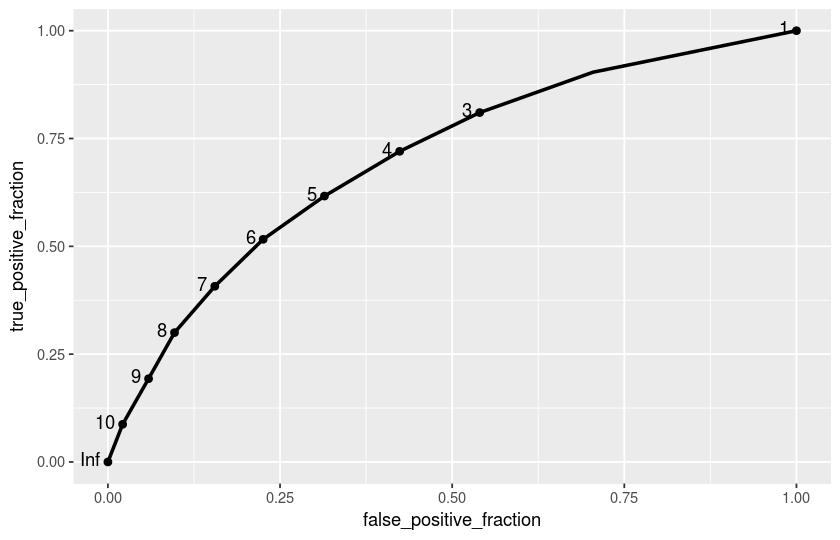

In [4]:
roc_recid=ggplot(raw_data) +
    aes(d=is_recid, m=decile_score) +
    geom_roc()
roc_recid

#### 1. Plot ROC curves for violent recidivism using violent decile scores as the predictor

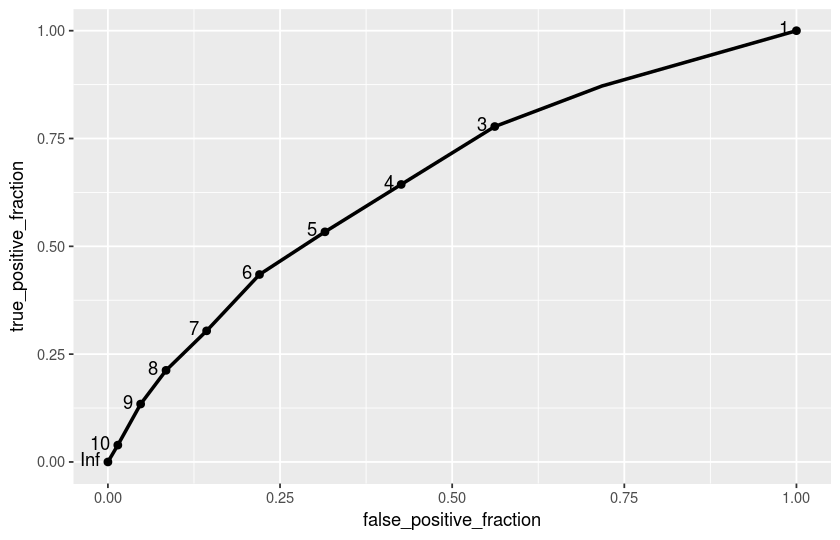

In [5]:
roc_v_recid=ggplot(raw_data) +
    aes(d=is_violent_recid, m=v_decile_score) +
    geom_roc()
roc_v_recid

#### 2. Compute the precision (PPV), recall, false positive rate, and false negative rate for predicting recidivism using 'High Risk' as the threshold for 'will recidivate'.

In [6]:
recall_precision=function(score_text){
    dataf = dplyr::select(raw_data, is_recid, score_text)
    dataf$will_recidivate = ifelse(dataf$score_text=="High", 1, 0)
    
    TP=sum(dataf$is_recid=="1" & dataf$will_recidivate=="1")
    TN=sum(dataf$is_recid=="0" & dataf$will_recidivate=="0")
    FP=sum(dataf$is_recid=="0" & dataf$will_recidivate=="1")
    FN=sum(dataf$is_recid=="1" & dataf$will_recidivate=="0")
    Recall=TP / sum(TP,FN)
    Precision=TP / sum(TP,FP)
    False_Positive_Rate=FP/sum(FP,TN)
    False_Negative_Rate=FN/sum(FN,TP)
    PR=data.frame(Recall, Precision,False_Positive_Rate,False_Negative_Rate)
    return(PR)
    
}

recall_precision(raw_data$score_text)

Recall,Precision,False_Positive_Rate,False_Negative_Rate
0.2999136,0.7419815,0.09671387,0.7000864


Compute the precision (PPV), recall, false positive rate, and false negative rate for predicting violent recidivism using 'High Risk' as the threshold for 'will recidivate'.

In [7]:
recall_precision=function(v_score_text){
    dataf = dplyr::select(raw_data, is_violent_recid, v_score_text)
    dataf$will_recidivate = ifelse(dataf$v_score_text=="High", 1, 0)
    
    TP=sum(dataf$is_violent_recid=="1" & dataf$will_recidivate=="1")
    TN=sum(dataf$is_violent_recid=="0" & dataf$will_recidivate=="0")
    FP=sum(dataf$is_violent_recid=="0" & dataf$will_recidivate=="1")
    FN=sum(dataf$is_violent_recid=="1" & dataf$will_recidivate=="0")
    Recall=TP / sum(TP,FN)
    Precision=TP / sum(TP,FP) 
    False_Positive_Rate=FP/sum(FP,TN)
    False_Negative_Rate=FN/sum(FN,TP)
    PR=data.frame(Recall, Precision,False_Positive_Rate,False_Negative_Rate)
    return(PR)
    
}

recall_precision(raw_data$v_score_text)

Recall,Precision,False_Positive_Rate,False_Negative_Rate
0.2124542,0.2436975,0.08444097,0.7875458


Now let's prepare for the bar graph
1. considering only Caucasian, Black, and Hispanic 
2. calculating likelihood that a defendant with each of the three risk score levels recidivates 
3. bar chart that have risk score in x axis, and the likelihood of recidivism in y axis, facet_grid by race and shows whether we are looking at violent or general recidivism.

In [8]:
non_violent <-raw_data %>%
        group_by(race, score = score_text, crime_type = is_recid) %>%
        summarise(counts=n())%>%
        filter((race=='Caucasian'| race=='Hispanic'|race=='African-American')) %>%
        mutate(prob = counts / sum(counts)) %>%
        filter(crime_type ==1)
       
non_violent

race,score,crime_type,counts,prob
African-American,High,1,771,0.7521951
African-American,Low,1,591,0.3883049
African-American,Medium,1,674,0.5865970
Caucasian,High,1,201,0.7282609
Caucasian,Low,1,502,0.3137500
Caucasian,Medium,1,322,0.5570934
Hispanic,High,1,40,0.5970149
Hispanic,Low,1,136,0.3042506
Hispanic,Medium,1,69,0.5609756


In [9]:
violent <-raw_data %>%
        group_by(race, score = v_score_text, crime_type = is_violent_recid) %>%
        summarise(counts=n())%>%
        filter((race=='Caucasian'| race=='Hispanic'|race=='African-American')) %>%
        mutate(prob = counts / sum(counts)) %>%
        filter(crime_type==1)
       
violent

race,score,crime_type,counts,prob
African-American,High,1,129,0.24248120
African-American,Low,1,187,0.09166667
African-American,Medium,1,179,0.15925267
Caucasian,High,1,24,0.19672131
Caucasian,Low,1,139,0.07273679
Caucasian,Medium,1,59,0.14014252
Hispanic,High,1,9,0.23684211
Hispanic,Low,1,35,0.07352941
Hispanic,Medium,1,12,0.09756098


In [10]:
violent_plus_nonviolent = bind_rows(Violent = violent, Non_Violent = non_violent, .id = "Crime")

In [11]:
violent_plus_nonviolent

Crime,race,score,crime_type,counts,prob
Violent,African-American,High,1,129,0.24248120
Violent,African-American,Low,1,187,0.09166667
Violent,African-American,Medium,1,179,0.15925267
Violent,Caucasian,High,1,24,0.19672131
Violent,Caucasian,Low,1,139,0.07273679
Violent,Caucasian,Medium,1,59,0.14014252
Violent,Hispanic,High,1,9,0.23684211
Violent,Hispanic,Low,1,35,0.07352941
Violent,Hispanic,Medium,1,12,0.09756098
Non_Violent,African-American,High,1,771,0.75219512


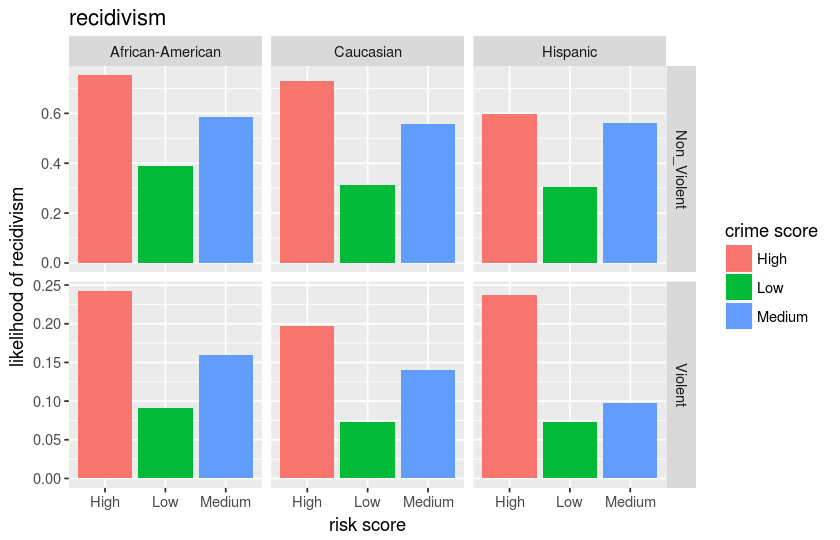

In [12]:
ggplot(violent_plus_nonviolent) +
    ggtitle("recidivism")+
    aes(x=score, y = prob, fill=score)+
    geom_bar(stat="identity",position=position_dodge()) +
    facet_grid(Crime~race, scale="free_y")+
    xlab("risk score")+
    ylab("likelihood of recidivism")+
    labs(fill = "crime score")

##### 2. Compute the False Positive Rate for each race: what fraction of defendants who do not recidivate receive a high risk score?

In [42]:
race_wise_FPR=function(filter_race){

    dataf = dplyr::select(raw_data, race, is_recid, score_text) %>%
        filter(race == filter_race)
    dataf$will_recidivate = ifelse(dataf$score_text=="High", 1, 0)

    TN=sum(dataf$is_recid=="0" & dataf$will_recidivate=="0")
    FP=sum(dataf$is_recid=="0" & dataf$will_recidivate=="1")
    False_Positive_Rate=FP/sum(FP,TN)
   

    return(False_Positive_Rate)
}

FPRate_Causasian=race_wise_FPR('Caucasian')
FPRate_AfricanAmerican=race_wise_FPR('African-American')
FPRate_Hispanic=race_wise_FPR('Hispanic')

df = data.frame(FPRate_Causasian, FPRate_AfricanAmerican, FPRate_Hispanic)
df



FPRate_Causasian,FPRate_AfricanAmerican,FPRate_Hispanic
0.05248425,0.153012,0.06887755


##### 3. Compute the False Negative Rate for each race: what fraction of defendants who receive do recidivate receive a low risk score?

In [44]:
# FalseNegativeRate = FN/(FN+TP)
race_wise_FNR=function(filter_race){

    dataf = dplyr::select(raw_data, race, is_recid, score_text) %>%
        filter(race == filter_race)
    dataf$will_recidivate = ifelse(dataf$score_text=="Low", 1, 0)

    TP=sum(dataf$is_recid=="1" & dataf$will_recidivate=="1") 
    FN=sum(dataf$is_recid=="1" & dataf$will_recidivate=="0")
    False_Negative_Rate=FN/sum(FN,TP)
   

    return(False_Negative_Rate)
}

FNRate_Causasian=race_wise_FPR('Caucasian')
FNRate_AfricanAmerican=race_wise_FPR('African-American')
FNRate_Hispanic=race_wise_FPR('Hispanic')

df = data.frame(FNRate_Causasian, FNRate_AfricanAmerican, FNRate_Hispanic)
df



FNRate_Causasian,FNRate_AfricanAmerican,FNRate_Hispanic
0.05248425,0.153012,0.06887755


##### 4. Compute the Positive Predictive Value (or Precision) for each race.

race,score_text,is_recid,counts,Positive_Predictive_Value
African-American,High,1,771,0.7521951
Caucasian,High,1,201,0.7282609
Hispanic,High,1,40,0.5970149


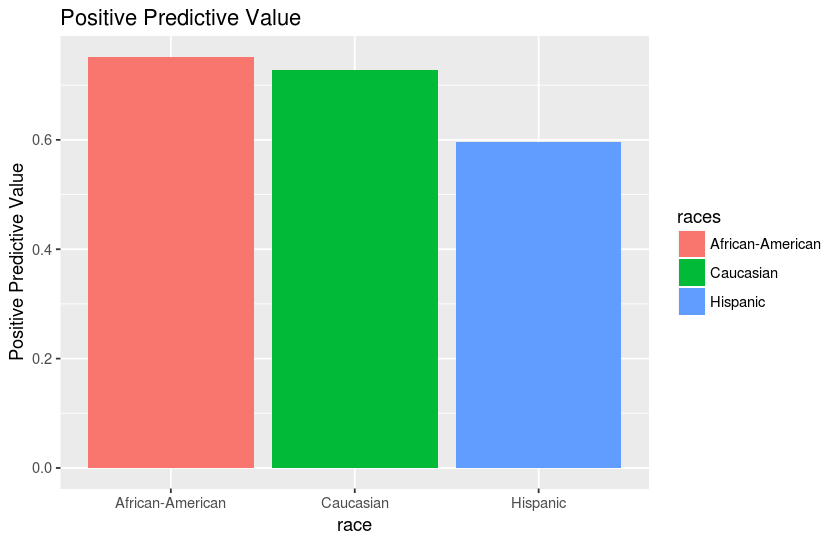

In [39]:
PPV_df<-raw_data %>%
        group_by(race, score_text, is_recid) %>%
        summarise(counts=n())%>%
        filter((race=='Caucasian'| race=='Hispanic'|race=='African-American')) %>%
        mutate(Positive_Predictive_Value  = counts / sum(counts)) %>%
        filter(is_recid==1,score_text=='High')
PPV_df

ggplot(PPV_df) +
    ggtitle("Positive Predictive Value")+
    aes(x=race, y = Positive_Predictive_Value, fill=race)+
    geom_bar(stat="identity",position=position_dodge()) +    
    xlab("race")+
    ylab("Positive Predictive Value")+
    labs(fill = "races")

##### 5. Compute the Negative Predictive Value for each race (what fraction of low-risk defendents do recidiviate).

race,score_text,is_recid,number_low_risk_defendents,negative_predictive_value
African-American,Low,1,591,0.3883049
Caucasian,Low,1,502,0.3137500
Hispanic,Low,1,136,0.3042506


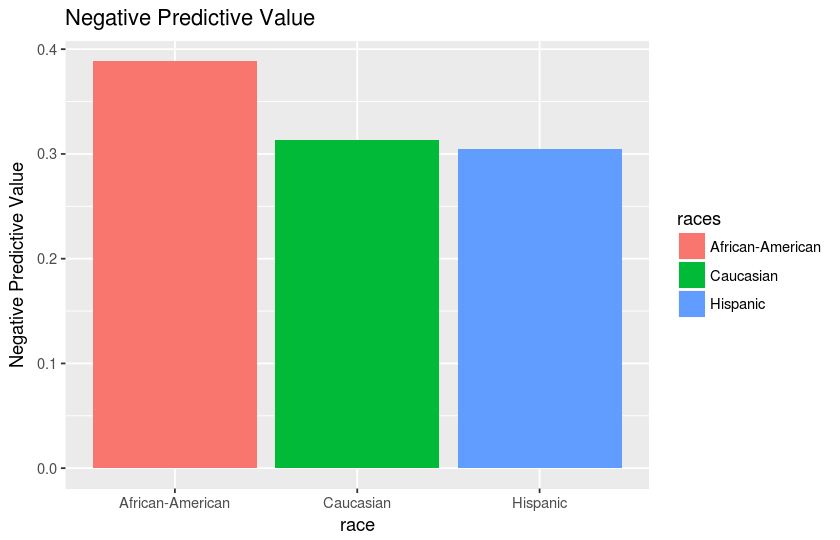

In [16]:
NPV_df<-raw_data %>%
        group_by(race, score_text, is_recid) %>%
        summarise(number_low_risk_defendents=n())%>%
        filter((race=='Caucasian'| race=='Hispanic'|race=='African-American')) %>%
        mutate(negative_predictive_value = number_low_risk_defendents / sum(number_low_risk_defendents)) %>%
        filter(is_recid==1,score_text=='Low')
NPV_df

ggplot(NPV_df) +
    ggtitle("Negative Predictive Value")+
    aes(x=race, y = negative_predictive_value, fill=race)+
    geom_bar(stat="identity",position=position_dodge()) +    
    xlab("race")+
    ylab("Negative Predictive Value")+
    labs(fill = "races")

##### 6. Plot ROC curves for each race (overlayed on top of each other — map the color and linetype aesthetics to race).

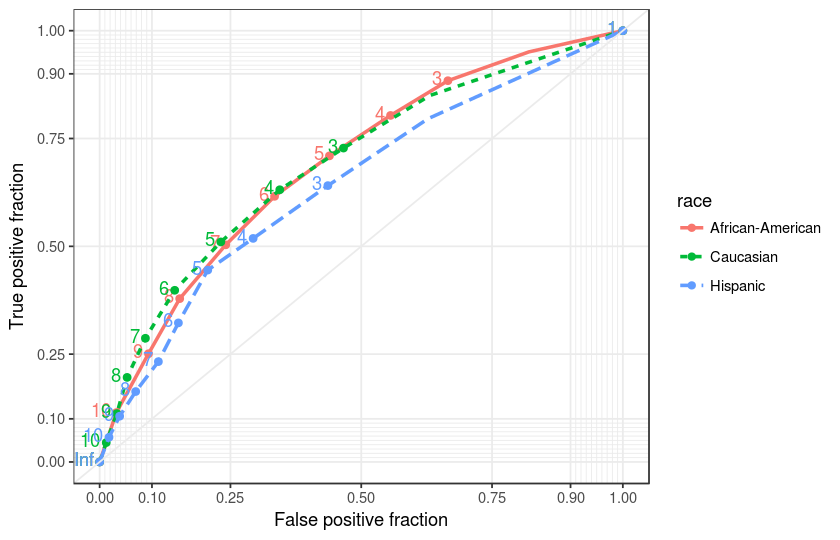

In [17]:
roc_recidivism = ggplot(raw_data %>% filter(race=='African-American' | race=='Caucasian' | race=='Hispanic')) +
                      aes(d=is_recid, m=decile_score, color=race,linetype=race) +
                      geom_roc()+style_roc()
roc_recidivism

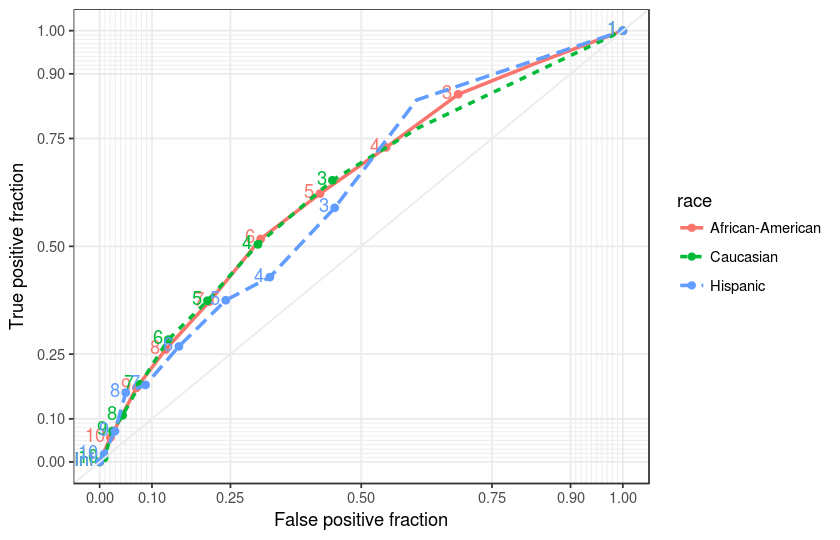

In [18]:
roc_violent_recidivism = ggplot(raw_data %>% filter(race=='African-American' | race=='Caucasian' | race=='Hispanic')) +
                      aes(d=is_violent_recid, m=v_decile_score, color=race,linetype=race) +
                      geom_roc()+style_roc()
roc_violent_recidivism

#### 1. Based on these analyses, write 1-2 paragraphs about how members of different races experience the prediction system.

- The analysis shows that the likelihood of violent and non violent recidivism is higher for African-American people then the other two groups. The likelihood of violent and non violent recidivism is greater for Hispanic than Caucasian race. A detail survey shows that African-American race are predicted for high risk score while they do not recidivate. This is shown by the false positive rate calculation where the false positive rate for Afrian-American people is at 0.153 which is two times greater than Causasian and Hispanic race. So, African-American people has greater probability of getting high risk score while they donot recidivate. It is also interesting to find that the prediction system which predicted that African-American people as low risk while in reality they recidivated higher than other group of people.

#### 2. Write 1–2 paragraphs about why you think different metrics tell different stories. How can PPV be similar but FPR or FNR be different? Think about a confusion matrix to help you with this.

- Here, Positive predictive value (PPV) defines the probability that the defedents of each race that are given the high score of risk do recidivate. PPV represents a proportion of defendents with high risk score and recidivate with respect to the total defendents that have high risk score and recidivate(TP/TP+FP).

- FPR defines the fraction of defendants who do not recidivate receive a high risk score.
- FNR defines the fraction of defendants who receive do recidivate receive a low risk score.
- From the observations:
    - PPV across all the race is same because the proportion of the true positive and false positive 
        are same across all the race.
    - FPR on the other hand is higher for the African-American race because more people for this race 
    are rated high risk where as in reality they do not recidivate.
    - FNR is also higher for African-American people because the false negative for this race is 
    unexpectedly greater than true negatives as compared to other races.

- PPV metric cares about the statistics gathered on the examples that were accurately and inaccurately predicted as positives (i.e. the true positive and false positive examples). So two examples with (TP=90, FP=10) and (TP=9, FP=1) would suggest the same PPV metrics. FPR on the other hand only cares about the statistics for the predicted values of originally negative examples (i.e. FP and TN). So, following the two examples from above, we can have very different values of FP and TN even for the cases that have same PPV values. Similarly with FNR, this only cares about the statistics for the predicted values of originally positive examples (i.e. FN and TP). We can clearly see, that different classifiers might populate the confusion matrix with different numbers but the PPV ratio might be same for two different classifiers, but FPR and FNR ratios.